In [ ]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/mobilenet-h5/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5
/kaggle/input/plant-pathology-2020-fgvc7/sample_submission.csv
/kaggle/input/plant-pathology-2020-fgvc7/train.csv
/kaggle/input/plant-pathology-2020-fgvc7/test.csv
/kaggle/input/plant-pathology-2020-fgvc7/images/Test_1743.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Test_262.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Train_1524.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Train_1336.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Train_1461.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Train_1797.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Test_1499.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Train_1170.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Test_1259.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Test_422.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Test_636.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Test_1395.j

In [ ]:
import pandas as pd
import numpy as np
import os
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

2025-08-20 05:36:48.844882: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755668208.866894     453 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755668208.873646     453 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
df = pd.read_csv('/kaggle/input/plant-pathology-2020-fgvc7/train.csv')

df['label'] = df[['healthy', 'scab', 'rust', 'multiple_diseases']].idxmax(axis=1)

df['image'] = df['image_id'].apply(lambda x: f"/kaggle/input/plant-pathology-2020-fgvc7/images/{x}.jpg")

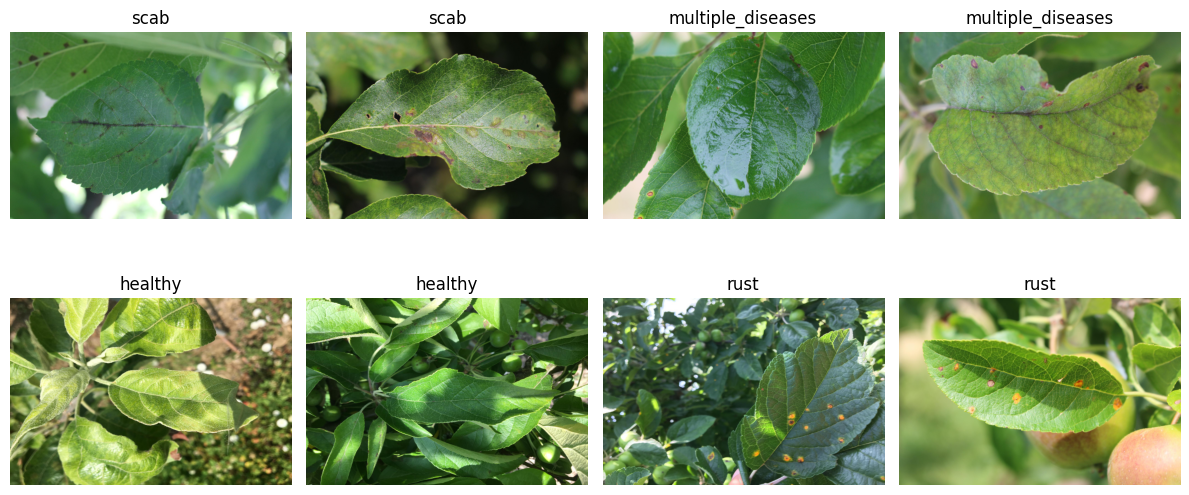

In [ ]:
classes = df['label'].unique()

plt.figure(figsize=(12, 6))
i = 1
for label in classes:
    sample = df[df['label'] == label].sample(2)
    for row in sample.itertuples():
        img = mpimg.imread(row.image)
        plt.subplot(2, 4, i)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')
        i += 1

plt.tight_layout()
plt.show()


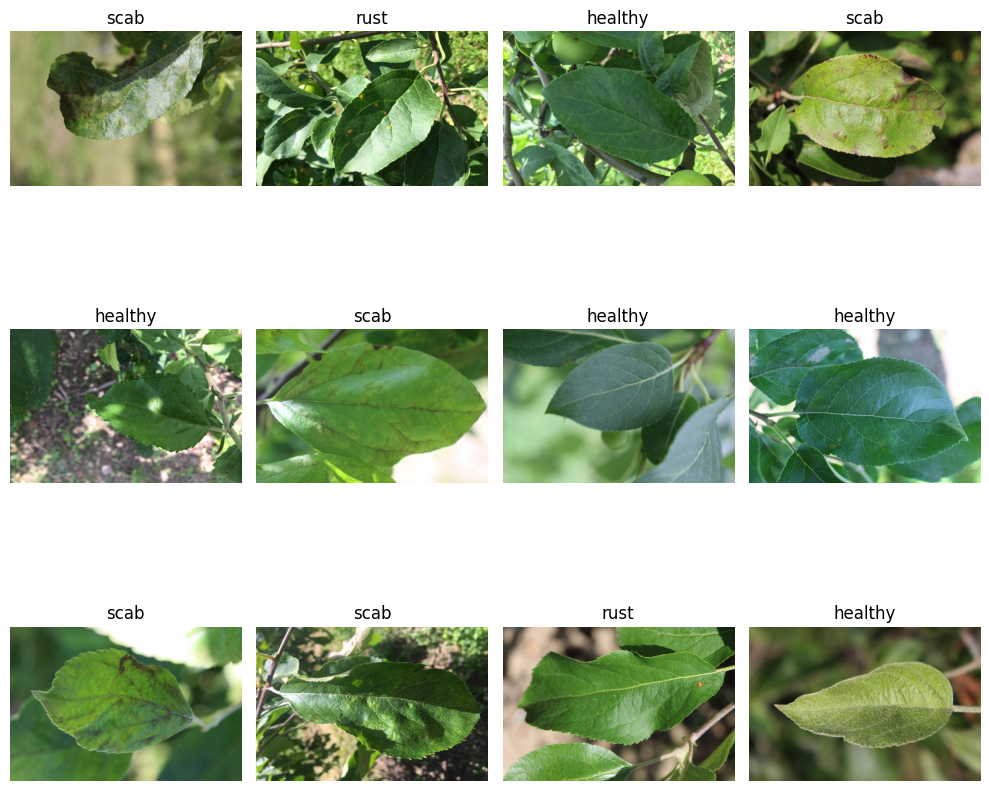

In [ ]:
sample_df = df.sample(12)

plt.figure(figsize=(10, 10))
for i, row in enumerate(sample_df.itertuples()):
    img = mpimg.imread(row.image)
    plt.subplot(3, 4, i+1)
    plt.imshow(img)
    plt.title(row.label)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
datagen = ImageDataGenerator(
    validation_split=0.2,
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2
)

train_generator = datagen.flow_from_dataframe(
    dataframe=df,
    x_col='image',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    subset='training',
    batch_size=32,
    shuffle=True
)

val_generator = datagen.flow_from_dataframe(
    dataframe=df,
    x_col='image',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    subset='validation',
    batch_size=32,
    shuffle=False
)

Found 1457 validated image filenames belonging to 4 classes.
Found 364 validated image filenames belonging to 4 classes.


In [ ]:
!pip install kaggle


In [ ]:
base_model = MobileNetV2(
    include_top=False,
    input_shape=(224, 224, 3),
    weights="/kaggle/input/mobilenet-h5/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5"
)
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
output = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

I0000 00:00:1755668222.937160     453 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [ ]:

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])


early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)


history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1755668233.998307     519 service.cc:148] XLA service 0x7cebc81412e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755668233.998340     519 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1755668234.939096     519 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/46 ━━━━━━━━━━━━━━━━━━━━ 9:01 12s/step - accuracy: 0.1562 - loss: 2.1880

I0000 00:00:1755668238.326211     519 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


46/46 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.3070 - loss: 1.5523 - val_accuracy: 0.6566 - val_loss: 0.9717
Epoch 2/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 38s 818ms/step - accuracy: 0.5835 - loss: 1.0055 - val_accuracy: 0.7500 - val_loss: 0.7759
Epoch 3/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 36s 793ms/step - accuracy: 0.6828 - loss: 0.8530 - val_accuracy: 0.7747 - val_loss: 0.6882
Epoch 4/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 37s 807ms/step - accuracy: 0.7202 - loss: 0.7566 - val_accuracy: 0.7857 - val_loss: 0.6290
Epoch 5/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 38s 825ms/step - accuracy: 0.7585 - loss: 0.6894 - val_accuracy: 0.7967 - val_loss: 0.6073
Epoch 6/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 39s 855ms/step - accuracy: 0.7545 - loss: 0.6593 - val_accuracy: 0.8077 - val_loss: 0.5820
Epoch 7/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 37s 817ms/step - accuracy: 0.7885 - loss: 0.5847 - val_accuracy: 0.8187 - val_loss: 0.5365
Epoch 8/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 42s 925ms/step - accuracy: 0.8078 - loss: 0.5655 - val_accuracy: 0.7995 -

In [ ]:
model.save("/kaggle/working/my_model.keras")

model.save_weights("/kaggle/working/my_weights.weights.h5")


In [ ]:

val_loss, val_accuracy = model.evaluate(val_generator)

print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 625ms/step - accuracy: 0.7986 - loss: 0.5887
Validation Accuracy: 0.8159
Validation Loss: 0.5169


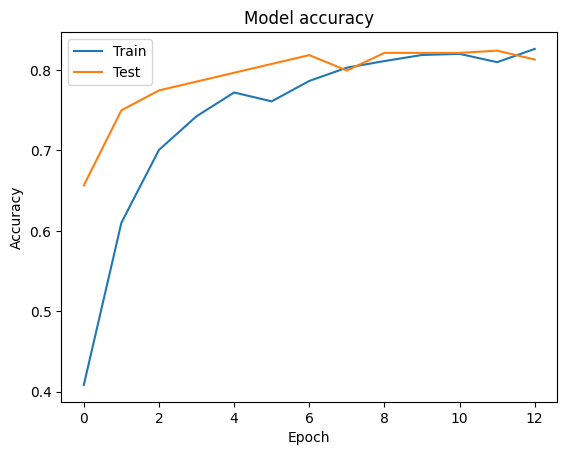

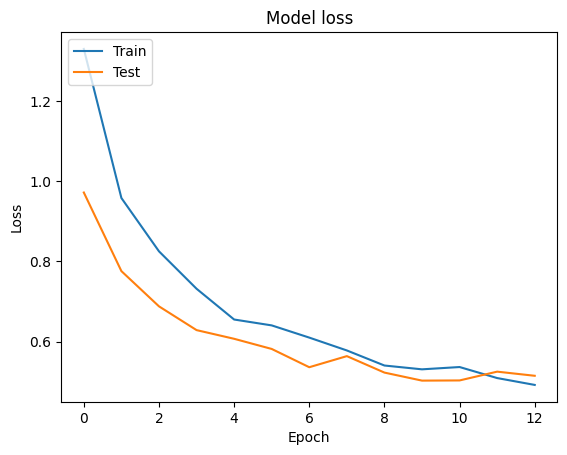

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
import numpy as np


val_generator.reset()
Y_true = val_generator.classes


Y_pred = model.predict(val_generator)
Y_pred_classes = np.argmax(Y_pred, axis=1)


labels = list(val_generator.class_indices.keys())


print(classification_report(Y_true, Y_pred_classes, target_names=labels))

12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 845ms/step
                   precision    recall  f1-score   support

          healthy       0.68      0.88      0.77        88
multiple_diseases       0.00      0.00      0.00        20
             rust       0.81      0.87      0.84       116
             scab       0.88      0.79      0.83       140

         accuracy                           0.79       364
        macro avg       0.59      0.63      0.61       364
     weighted avg       0.76      0.79      0.77       364



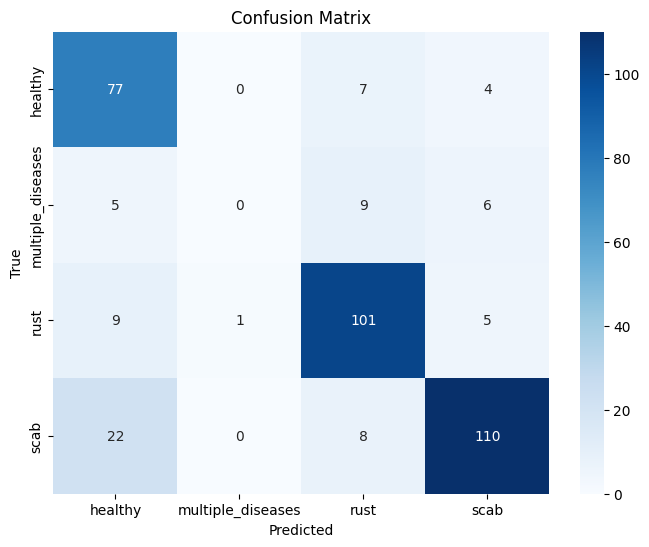

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(Y_true, Y_pred_classes)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
test_df = pd.read_csv("/kaggle/input/plant-pathology-2020-fgvc7/test.csv")

test_df['image'] = test_df['image_id'].apply(lambda x: f"/kaggle/input/plant-pathology-2020-fgvc7/images/{x}.jpg")

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image',
    y_col=None,
    target_size=(224, 224),
    class_mode=None,
    shuffle=False
)

Found 1821 validated image filenames.


In [ ]:

predictions = model.predict(test_generator)


submission = pd.DataFrame(predictions, columns=['healthy', 'multiple_diseases', 'rust', 'scab'])


submission.insert(0, 'image_id', test_df['image_id'])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


57/57 ━━━━━━━━━━━━━━━━━━━━ 43s 703ms/step


In [ ]:
submission.to_csv("submission.csv", index=False)